# Case Study: Math PhD Exchange

This data set is derived from the article ["Eigenvector-Based Centrality Measures for Temporal Networks
"](https://arxiv.org/abs/1507.01266) by Taylor, Myers, Clauset, Porter, and Mucha, which was in turn scraped from the [Mathematics Geneology Project](https://www.genealogy.math.ndsu.nodak.edu/). There is an entry $i\rightarrow j$ in year $t$ if a mathematician graduated in year $t$ from university $j$ and thereafter supervised at least one PhD thesis at university $i$. This is a proxy for hiring data: we are assuming, essentially, that this mathematician was hired ("endorsed") by $i$ in or around year $t$. 

## Data Limitations

There are several limitations in these data implied by the collection process. 

1. If a mathematician is hired in year $t$, then they are unlikely to show up in the data set until roughly year $t+\tau$, where $\tau\approx 5 \pm 2$ is the approximate amount of time required to complete a PhD thesis. 
2. If a mathematician is hired sequentially by departments $i$ and $i'$, both $i$ and $i'$ will be taken to have endorsed this mathematician *in the same year* $t$, even though the actual time in which $i'$ hired the mathematician may be well after $i$. This raises the potential for causality violations. 

To address limitation 1., we omit the final six years of the data set. We'll study the years 1960-2000. 

In [2]:
import numpy as np

from py.simulation import *
from py.estimation import *
from py.features import *
from py.utils import *
from py.prep_data import *
from py.learner import learner

from matplotlib import pyplot as plt

In [3]:
# visualization commands

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"
cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']

from matplotlib.gridspec import GridSpec


# Samples

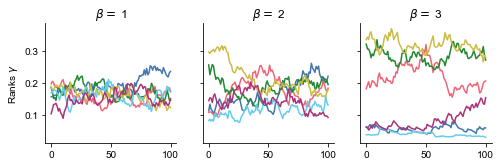

In [4]:
n = 6

A0 = np.random.randint(1, size = (n,n))
lam = .9
beta = np.array([2])
n_rounds = 200
m_updates = 2

BETAS = [np.array([i]) for i in range(1,4)]
fig, axarr = plt.subplots(1,3, sharey=True, figsize = (8,2.2))

L = learner()

L.set_score(
    score_function = lambda A: SpringRank.SpringRank(A.T)
)

L.set_features([
    lambda s: np.tile(s, (n,1)),
])

for i in range(3):

    T = L.simulate(beta = BETAS[i], 
                   lam = lam, 
                   A0 = A0,
                   n_rounds = n_rounds,
                   update = stochastic_update,
                   m_updates = m_updates)

    # with known parameters, infer the rate matrix from the fake data

    L.set_data(T, T[0])
    L.compute_state_matrix(lam = lam)
    L.compute_score()
    L.compute_features()
    L.compute_rate_matrix(beta = beta)
    for j in range(n):
        axarr[i].plot(L.GAMMA.mean(axis = 1)[100:,j], color = cset[j])
    
    axarr[i].spines['top'].set_visible(False)
    axarr[i].spines['right'].set_visible(False)
    axarr[i].set(title = r'$\beta = $ ' + str(BETAS[i][0]))

    
axarr[0].set(ylabel = r'Ranks $\gamma$')
plt.savefig('fig/traces.png', bbox_inches = 'tight', dpi = 300) 

# Math PhD Figure

First we read the data. In order to ensure connectedness of the endorsement matrix across many time periods, we restrict the data to only the top 100 schools by placement. 

In [5]:
data_dir = 'data/PhD Exchange Network Data/'

top_n = 70
T, labels, timesteps = prep_math_phd(data_dir, top_n = top_n) 

In order to ensure that the endorsement matrix is weakly connected at the initial condition, we are going to take all of the pre-1960 data and aggregate it into the initial state matrix. In order to address limitation 1) above, we are also going to exclude the years 2001-onward from analysis. 

In [6]:
T, timesteps, A0, n_obs = initial_condition(T, timesteps, t_start = 14, t_end = 55)

## Estimation

In [7]:
# SpringRank based inference: this call might take a while. It may be necessary to adjust the bounds 
# in order to ensure that the optimization converges to the correct value. 

L = learner()

L.set_score(
    score_function = lambda A: SpringRank.SpringRank(A.T)
)

L.set_features([
    lambda s: np.tile(s, (len(s),1)),
])

L.set_data(T, A0)

pars = L.ML(lam0 = .7, 
           alpha0 = 10**(-4), 
           tol = 10**(-1), 
           step_cap = .05,
           print_updates = True)
pars

computing memory hyperparameter lambda
Lambda = 0.75, LL = 21615.349443231597
Lambda = 0.8, LL = 21548.156634128325
Lambda = 0.8500000000000001, LL = 21497.352057128788
Lambda = 0.9000000000000001, LL = 21474.526381471012
Lambda = 0.9014912283186278, LL = 21474.51915227525
computing parameter vector beta


{'lam': 0.9014912283186278,
 'beta': array([2.37770061]),
 'LL': -21474.51915227525}

In [8]:
H = L.estimate_hessian(pars['lam'], pars['beta'])
H
stderrs = np.sqrt(np.diag(np.linalg.inv(-H)))

In [9]:
b_grid = 101
lam_grid = 101

BETA = np.linspace(1, 5, b_grid)
LAMBDA = np.linspace(0.5,1, lam_grid)

M = L.likelihood_surface(LAMBDA, BETA)

## Inferred Rank Dynamics

In [10]:
L.set_data(T, T[0])
L.compute_state_matrix(lam = pars['lam'])
L.compute_score()
L.compute_features()
L.compute_rate_matrix(beta = pars['beta'])

# Visualization

In [11]:
# cosmetics

shortener = {
    'Massachusetts Institute of Technology' : 'MIT',
    'University of California, Berkeley' : 'Berkeley', 
    'Stanford University' : 'Stanford',
    'Princeton University' : 'Princeton',
    'Harvard University' : 'Harvard',
    'Yale University' : 'Yale',
    'The University of Chicago' : 'Chicago',
    'California Institute of Technology' : 'Caltech',
    'University of Wisconsin-Madison' : 'Wisconsin'
}


SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
TITLE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=TITLE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [12]:
highlights = ['MIT', 'Berkeley', 'Stanford', 'Harvard', 'Princeton', 'Chicago']

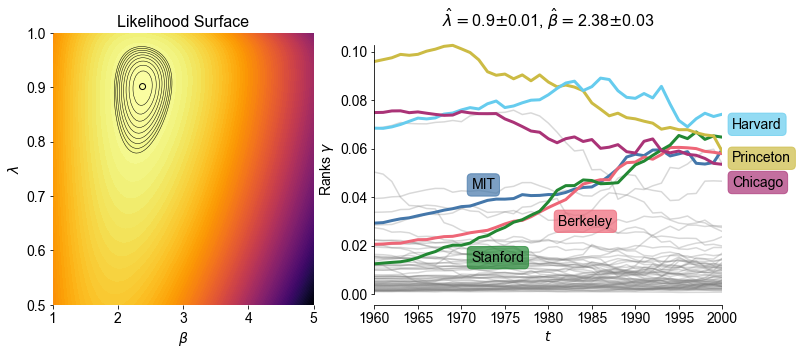

In [13]:
fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)

im = ax1.contourf(BETA, LAMBDA, M, levels = 100, cmap = 'inferno')
ax1.contour(BETA, LAMBDA, M, 
               levels = np.linspace(M.max() - 100, 
                                    M.max(), 10), 
               linewidths = .5, 
               colors = 'black', 
               linestyles = 'solid')

# cb = plt.colorbar(im)
# cb.outline.set_visible(False)

#     ax.scatter(beta, lam, color = 'black')

ax1.set(xlabel = r'$\beta$',
       ylabel = r'$\lambda$',
       title = 'Likelihood Surface')

ax1.scatter(pars['beta'][0], pars['lam'], color = 'black', facecolor = 'None')

for pos in ['top', 'right', 'left', 'bottom']: 
    ax1.spines[pos].set_visible(False)


ax2 = fig.add_subplot(122)
p = ax2.plot(timesteps, L.GAMMA.mean(axis = 1), color = 'grey', alpha = .3)

k = 0

positions = {
    'Harvard' : [2000, .07],
    'Chicago': [2000, .046], 
    'MIT' : [1970, .045], 
    'Stanford' : [1970, 0.015], 
    'Berkeley' : [1980, 0.03],
    'Princeton' : [2000, 0.056]
}

for l in range(L.n):
    try: 
        name = shortener[labels[l]]
        if name in highlights:
            ax2.plot(timesteps, L.GAMMA.mean(axis = 1)[:,l], alpha = 1, linewidth = 3, 
                     label = name, color = cset[k])
            ax2.annotate(name,
                  xy=(positions[name][0], positions[name][1]), xycoords='data',
                  xytext=(10, 0), textcoords='offset points',
                  size=14, va="center", color = 'black',
                  bbox=dict(boxstyle="round",  color = cset[k], alpha = .7))
            k += 1
    except KeyError:
        pass


for pos in ['top', 'right']: 
    ax2.spines[pos].set_visible(False)

ax2.spines['left'].set_bounds(0, L.GAMMA.max())
ax2.spines['bottom'].set_bounds(timesteps.min(), timesteps.max())
ax2.set(
       xlim = (timesteps.min(), timesteps.max()),
       xlabel = r'$t$',
       ylabel = r'Ranks $\gamma$',
       title = r'$\hat{\lambda} = $' + str(round(pars['lam'], 2)) + r'$\pm$' + str(round(stderrs[0], 2)) + r', $\hat{\beta} = $' + str(round(pars['beta'][0], 2)) + r'$\pm$' + str(round(stderrs[1], 2)))

gs = GridSpec(1, 2, width_ratios=[3, 4])

ax1.set_position(gs[0].get_position(fig))
ax2.set_position(gs[1].get_position(fig))

plt.savefig('fig/math_phd_poster.png', dpi = 300, bbox_inches = 'tight')        

# Phase Transition / Bifurcation

In [14]:
n = 2
L = learner()

A0 = np.ones((n,n))

L = learner()

L.set_score(
    score_function = lambda A: SpringRank.SpringRank(A.T)
)

L.set_features([
    lambda s: np.tile(s, (n,1)),
])

n_rounds = 10
beta = np.array([2])
lam = .1
m_updates = 1

In [15]:
def compute_bifurcation(beta, n_rounds = 100, lam = 0.99, m_updates = 1, n = 2):
    
#     if beta < 2: 
#         A0 = np.ones((n,n))
#     else:
#     A0 = np.random.rand(n,n)
    A0 = np.ones((n,n))
    A0[0,1] += .01
    A0 = A0 / A0.sum()
    
    T = L.simulate(beta = beta,
                       lam = lam, 
                       A0 = A0,
                       n_rounds = n_rounds,
                       update = deterministic_update,
                       m_updates = m_updates)

    L.set_data(T, T[0])
    L.compute_state_matrix(lam)
    L.compute_score()
    L.compute_features()
    L.compute_rate_matrix(beta)
    GAMMA = np.sort(L.GAMMA, axis = 2)
    return(GAMMA[int(n_rounds/2):].mean(axis = (0,1)))

In [16]:
b_grid = 101
BETAS = np.linspace(1, 3, b_grid)

V = np.zeros((b_grid, 2))

# note: this call takes a long time...

for i in range(b_grid):
    V[i] = compute_bifurcation(np.array([BETAS[i]]), n = 2, n_rounds = 100, m_updates = 1, lam = lam)

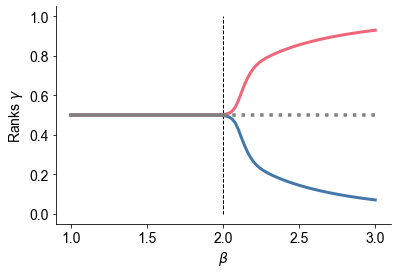

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
for pos in ['top', 'right']: 
    ax.spines[pos].set_visible(False)

ax.vlines(x = np.array([2]), ymin = 0, ymax = 1, linestyle = '--', linewidth=1)    
for j in range(2):
    ax.plot(BETAS, V[:,j], color = cset[j], linewidth = 3)

ax.plot([1,2], [0.5, 0.5], color = 'gray', linewidth = 3.5)
ax.plot([2,3], [0.5, 0.5], color = 'gray', linewidth = 3.5, linestyle = 'dotted')

ax.set(xlabel = r'$\beta$', 
       ylabel = r'Ranks $\gamma$')

plt.savefig('fig/bifurcation_poster.png', dpi = 300, bbox_inches = 'tight')        

[(0.5, 0.500001)]

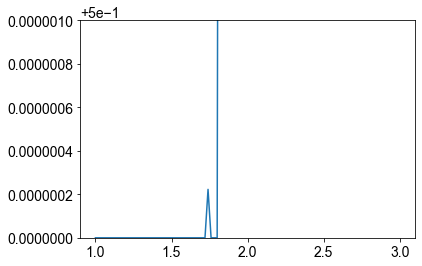